In [1]:
# This script completes the requirements for Term Project #2 for Galactic Structure, Winter 2017
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sci
from scipy.optimize import curve_fit
import astroML.lumfunc as lum
% matplotlib inline

In [2]:
tru = pd.read_csv('LSSTsimWDtruth60.dat',skiprows=2,delim_whitespace=True,names=['RA','Dec','u','g','r','i','z',
                                                                                 'y','M_r','log_g','v_r','v_phi',
                                                                                 'v_z','mod_typ','gal_pop'])
obs = pd.read_csv('LSSTsimWDobs60.dat',skiprows=2,delim_whitespace=True,names=['RA','Dec','uObs','uErr','gObs',
                                                                               'gErr','rObs','rErr','iObs','iErr',
                                                                               'zObs','zErr','yObs','yErr','piObs',
                                                                               'piErr','muRA_obs','muDec_obs','muErr'])

tru = tru.dropna()
obs = obs.dropna()

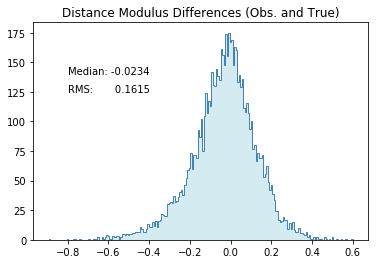

If there are  7156  WDs in this sample, (which covers an area of ~60 square degrees), then the number of WDs in 20000 square degrees will be  39756 , nearly 5 times as many more WDs.


In [138]:
# Part A
# Define a "Gold Parallax" sample
# signal-to-noise ratio > 10
# [where piObs/piErr > 10]
s2noise   = obs.piObs/obs.piErr
gold_mask = s2noise > 10
tr_G = tru[gold_mask]
ob_G = obs[gold_mask]

# From WDob_gold, determine distance & dist mod
# from parallax measurement:
# D/kpc=1 milliarcsec/piObs
ob_G = ob_G.assign(Dpc = 1/(ob_G.piObs/1000.))         # WDobs.piObs in milliarcsec
ob_G = ob_G.assign(Dmod = -5 + (5*np.log10(ob_G.Dpc))) # distance must be in parsecs

# From WDtr_gold, determine dist mod from M_r and m
# Compare to WDob_gold_Dmod
tr_G = tr_G.assign(Dmod = tr_G.r - tr_G.M_r)            # apparent - absolute magnitudes in r-band

dDmod = ob_G.Dmod - tr_G.Dmod

# Clip at 3-sigma
from astropy import stats
ob_G = ob_G.assign(dDmod_s3 = stats.sigma_clip(dDmod,sigma=3))

# Calculate median
dDmod_median = np.median(ob_G.dDmod_s3)

# Calculate root-mean-square
dDmod_rms = np.sqrt(np.mean(ob_G.dDmod_s3**2))

plt.hist(ob_G.dDmod_s3,bins=200,histtype='bar',color='LightBlue',alpha=0.5)
plt.hist(ob_G.dDmod_s3,bins=200,histtype='step',color='SteelBlue')
plt.title('Distance Modulus Differences (Obs. and True)')
plt.text(-0.8,140,'Median: %.4f'%dDmod_median)
plt.text(-0.8,125,'RMS:       %.4f'%dDmod_rms)
plt.show()

print('If there are ',len(ob_G.dDmod_s3),' WDs in this sample, (which covers an area of \
~60 square degrees), then the number of WDs in 20000 square degrees will be ', 
      round(len(ob_G.dDmod_s3)*(20000/(60**2))),', nearly 5 times as many more WDs.')

The RMS and median are quite small, I would have expected greater variation across the data. The data appears fairly Guassian, which I consider surprising, though perhaps it has to do with a Gaussian distribution present in either the observed or true data. 

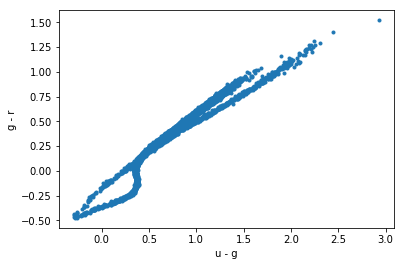

In [123]:
# Plot g-r vs u-g for the Gold Sample
ob_G = ob_G.assign(g_r = ob_G.gObs - ob_G.rObs)
ob_G = ob_G.assign(u_g = ob_G.uObs - ob_G.gObs)
ob_G = ob_G.assign(M_r   = ob_G.rObs - ob_G.Dmod)

plt.plot(ob_G.u_g,ob_G.g_r,'.')
plt.ylabel('g - r')
plt.xlabel('u - g')
plt.show()

This plot does look crisper than Figure 23 of Ivezic et. al. 2007; however, it also appears that there are much fewer WDs in our sample.

        3        2
0.7984 x - 1.43 x + 4.138 x + 12.68


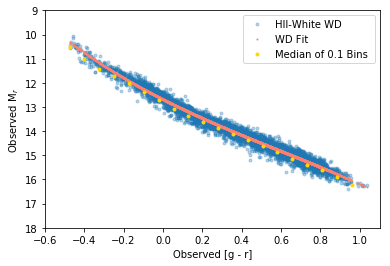

In [5]:
# Part B
# Estimate absolute r-band mag using
# Mobs = rObs - DMobs
# where DMobs = dist mod from parallax, WDob_gold_Dmod
T1_mask = tr_G.mod_typ == 1

plt.plot(ob_G.g_r[T1_mask],ob_G.M_r[T1_mask],'.',label='HII-White WD',alpha=0.3)
plt.ylabel(r'Observed M$_r$')
plt.xlabel('Observed [g - r]')

# Bin our M_r values in bins of (g-r) ~ 0.1 as suggested
M_r_bin = (np.max(ob_G.g_r[T1_mask]) - np.min(ob_G.g_r[T1_mask])) / 10
#print('Determine median M_r in ~ ',M_r_bin,' mag (g - r) bins')

M_r_binned  = sci.binned_statistic(ob_G.g_r[T1_mask],ob_G.M_r[T1_mask],statistic='median',bins=20)
M_r_medians = M_r_binned[0]
M_r_gr_bins = M_r_binned[1]
M_r_gr_bins = M_r_gr_bins[:-1]

fit = np.polyfit(ob_G.g_r[T1_mask],ob_G.M_r[T1_mask],3)
pfit = np.poly1d(fit)
print(pfit)

plt.plot(ob_G.g_r[T1_mask],pfit(ob_G.g_r[T1_mask]),'.',color='Salmon',markersize=2,label='WD Fit')
plt.plot(M_r_gr_bins,M_r_medians,marker='.',color='Gold',linestyle='None',label='Median of 0.1 Bins ')
plt.ylim(18,9)
plt.xlim(-0.6,1.1)
plt.legend(loc=1)
plt.show()

I determined a 3rd order polynomial fit was suffient to well match the data. Any larger order polynomial did not result in a better fit, indicating that increasing the degree of the polynomial would be overfitting.

In [7]:
# Part C
# Define Gold Proper Motion Sample
# observed r-band < 24.5
# rObs < 24.5
goldpm_mask     = obs.rObs < 24.5
ob_Gpm = obs[goldpm_mask]
tr_Gpm = tru[goldpm_mask]
tr_Gpm = tr_Gpm[ob_Gpm.piObs >= 0]
ob_Gpm = ob_Gpm[ob_Gpm.piObs >= 0]

ob_Gpm = ob_Gpm.assign(prop_mo = ((ob_Gpm.muRA_obs**2 + ob_Gpm.muDec_obs**2)**(1./2.))) # milliarcsec/yr
ob_Gpm = ob_Gpm.assign(SNR = (ob_Gpm.prop_mo/ob_Gpm.muErr))
print('Total # in gold pm sample: ',len(ob_Gpm))
print('Total # in gold pm with SNR > 3: ',len(ob_Gpm[ob_Gpm.SNR >= 3.]))
print('So %.4f'%(len(ob_Gpm[ob_Gpm.SNR >= 3.])/len(ob_Gpm)*100),'% have a SNR > 3')

Total # in gold pm sample:  144128
Total # in gold pm with SNR > 3:  141283
So 98.0261 % have a SNR > 3


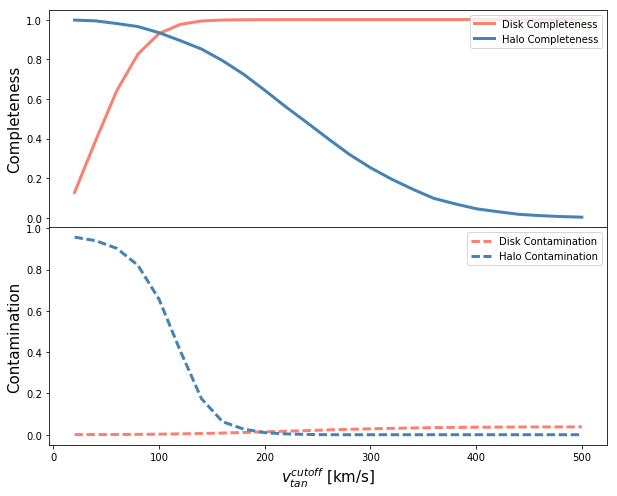

In [8]:
# Determine photometric parallax relations for DM and M_r for new sample
##### From Part B
# From WDob_gold, determine distance & dist mod
# from parallax measurement:
# D/kpc=1 milliarcsec/piObs
#ob_Gpm = ob_Gpm.assign(Dpc = 1./(ob_Gpm.piObs/1000.))         # WDobs.piObs in milliarcsec
#ob_Gpm = ob_Gpm.assign(Dmod = -5. + (5.*np.log10(ob_Gpm.Dpc))) # distance must be in parsecs
ob_Gpm = ob_Gpm.assign(M_r = pfit(ob_Gpm.gObs - ob_Gpm.rObs))
ob_Gpm = ob_Gpm.assign(Dmod = ob_Gpm.rObs - ob_Gpm.M_r)
ob_Gpm = ob_Gpm.assign(Dpc = 10**((ob_Gpm.Dmod + 5. )/5.))
#print(ob_Gpm)

# Use distance in pc and proper motion to determine tangential velocity
# tangential velocity (km/s) = 4.74 * proper motion (arcsec/yr) * distance (pcs)
ob_Gpm = ob_Gpm.assign(v_t = 4.74*(ob_Gpm.prop_mo/1000.)*(ob_Gpm.Dpc))  # km/s

# Use P from WDtrue to make a plot of P vs v_cutoff
v_cutoff = np.arange(0,501,20)  # km/s

s2noise  = ob_Gpm.piObs/ob_Gpm.piErr
SNR_mask = s2noise > 0.5
tr_Gpm   = tr_Gpm[SNR_mask]
ob_Gpm   = ob_Gpm[SNR_mask]

disk_comp = []
disk_cont = []
halo_comp = []
halo_cont = []
for i in range(1,len(v_cutoff)):
    ob_lt = ob_Gpm[ob_Gpm.v_t < v_cutoff[i]]
    ob_gt = ob_Gpm[ob_Gpm.v_t > v_cutoff[i]]
    tr_lt = tr_Gpm[ob_Gpm.v_t < v_cutoff[i]]
    tr_gt = tr_Gpm[ob_Gpm.v_t > v_cutoff[i]]
    
    lt_disk = ob_lt[tr_lt.gal_pop == 1.]  # Disk
    lt_halo = ob_lt[tr_lt.gal_pop == 2.]  # Halo
    gt_disk = ob_gt[tr_gt.gal_pop == 1.]  # Disk
    gt_halo = ob_gt[tr_gt.gal_pop == 2.]  # Halo
    
    disk_completeness  = len(lt_disk)/len(tr_Gpm[tr_Gpm.gal_pop == 1.])
    halo_completeness  = len(gt_halo)/len(tr_Gpm[tr_Gpm.gal_pop == 2.])
    
    disk_contamination = len(lt_halo)/len(ob_lt)
    halo_contamination = len(gt_disk)/len(ob_gt)
    
    disk_comp.append(disk_completeness)
    disk_cont.append(disk_contamination)    
    halo_comp.append(halo_completeness)
    halo_cont.append(halo_contamination)

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_ylabel('Completeness',size=15)
ax2.set_ylabel('Contamination',size=15)
ax2.set_xlabel(r'$v _{tan}^{cutoff}$ [km/s]',size=15)
ax1.plot(v_cutoff[1:],disk_comp,linestyle='-',color='Salmon',label='Disk Completeness',linewidth=3)
ax1.plot(v_cutoff[1:],halo_comp,linestyle='-',color='SteelBlue',label='Halo Completeness',linewidth=3)
ax1.legend(loc=1)
ax2.plot(v_cutoff[1:],disk_cont,linestyle='--',color='Salmon',label='Disk Contamination',linewidth=3)
ax2.plot(v_cutoff[1:],halo_cont,linestyle='--',color='SteelBlue',label='Halo Contamination',linewidth=3)
ax2.legend()
plt.subplots_adjust(hspace = .001)
plt.show()

In [122]:
# Part D & E:
# Define Disk and Halo sample (< 150 km/s & > 200 km/s)
# Get completeness and contamination
# Compute Luminosity Function for both samples (AstroML)
# Plot LF vs M_r and overplot true LF data & plot distance data

ob_Gpm_disks = ob_Gpm[ob_Gpm.v_t < 150.]
ob_Gpm_halos = ob_Gpm[ob_Gpm.v_t > 200.]

tr_Gpm_disks = tr_Gpm[ob_Gpm.v_t < 150.]
tr_Gpm_halos = tr_Gpm[ob_Gpm.v_t > 200.]

disks_comp = len(ob_Gpm_disks[tr_Gpm_disks.gal_pop == 1.])/len(tr_Gpm[tr_Gpm.gal_pop == 1.])
disks_cont = len(tr_Gpm_disks[tr_Gpm_disks.gal_pop == 2.])/len(ob_Gpm_disks)
halos_comp = len(tr_Gpm_halos[tr_Gpm_halos.gal_pop == 2.])/len(tr_Gpm[tr_Gpm.gal_pop == 2.])
halos_cont = len(tr_Gpm_halos[tr_Gpm_halos.gal_pop == 1.])/len(ob_Gpm_halos)

print(r'Completeness of disk samples (v$_cutoff$ < 150 km/s)',round(disks_comp,4),
      'and contamination',round(disks_cont,4),'.')
print(r'Completeness of halo samples (v$_cutoff$ > 200 km/s)',round(halos_comp,4),
      'and contamination',round(halos_cont,4),'.')

Completeness of disk samples (v$_cutoff$ < 150 km/s) 0.9963 and contamination 0.0069 .
Completeness of halo samples (v$_cutoff$ > 200 km/s) 0.6433 and contamination 0.0101 .


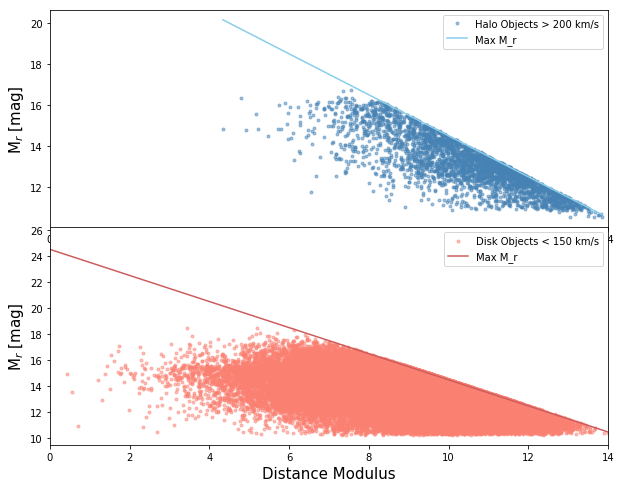

In [10]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(ob_Gpm_halos.Dmod,ob_Gpm_halos.M_r,marker='.',linestyle='None',
         color='SteelBlue',label='Halo Objects > 200 km/s',alpha=0.5)
ax2.plot(ob_Gpm_disks.Dmod,ob_Gpm_disks.M_r,marker='.',linestyle='None',
         color='Salmon',label='Disk Objects < 150 km/s',alpha=0.5)
ax1.set_xlim(0,14)
ax2.set_xlim(0,14)
ax1.set_ylabel(r'M$_r$ [mag]',size=15)
ax2.set_ylabel(r'M$_r$ [mag]',size=15)
ax2.set_xlabel('Distance Modulus',size=15)
plt.subplots_adjust(hspace = .001)

R_max = 24.5
Dmod_max = np.linspace(ob_Gpm_halos.Dmod.min(),ob_Gpm_halos.Dmod.max(),30,endpoint=True)
Dmod_diff = R_max - np.linspace(ob_Gpm_halos.Dmod.min(),ob_Gpm_halos.Dmod.max(),30,endpoint=True)
ax1.plot(Dmod_max,Dmod_diff,color='SkyBlue',label='Max M_r')
Dmod_max = np.linspace(ob_Gpm_disks.Dmod.min(),ob_Gpm_disks.Dmod.max(),30,endpoint=True)
Dmod_diff = R_max - np.linspace(ob_Gpm_disks.Dmod.min(),ob_Gpm_disks.Dmod.max(),30,endpoint=True)
ax2.plot(Dmod_max,Dmod_diff,color='IndianRed',label='Max M_r')
ax1.legend()
ax2.legend()
plt.show()

In [11]:
# Bootstrap Cminus method to determine Luminosity Functions
M_r_max_disk = R_max - ob_Gpm_disks.Dmod
Dmod_max_disk = R_max - ob_Gpm_disks.M_r
disk_D_bins  = np.linspace(ob_Gpm_disks.Dmod.min(),ob_Gpm_disks.Dmod.max(),31)
disk_Mr_bins = np.linspace(ob_Gpm_disks.M_r.min(),ob_Gpm_disks.M_r.max(),31)
disk_dist_x,disk_x_err,disk_dist_y,disk_y_err = lum.bootstrap_Cminus(ob_Gpm_disks.Dmod[0:1000],
                                                                     ob_Gpm_disks.M_r[0:1000],
                                                                     Dmod_max_disk[0:1000],M_r_max_disk[0:1000],
                                                                     disk_D_bins,disk_Mr_bins,Nbootstraps=10,
                                                                     normalize=True)

M_r_max_halo = R_max - ob_Gpm_halos.Dmod
Dmod_max_halo = R_max - ob_Gpm_halos.M_r
halo_D_bins  = np.linspace(ob_Gpm_halos.Dmod.min(),ob_Gpm_halos.Dmod.max(),21)
halo_Mr_bins = np.linspace(ob_Gpm_halos.M_r.min(),ob_Gpm_halos.M_r.max(),21)
halo_dist_x,halo_x_err,halo_dist_y,halo_y_err = lum.bootstrap_Cminus(ob_Gpm_halos.Dmod,
                                                                     ob_Gpm_halos.M_r,
                                                                     Dmod_max_halo,M_r_max_halo,
                                                                     halo_D_bins,halo_Mr_bins,Nbootstraps=10,
                                                                     normalize=True)


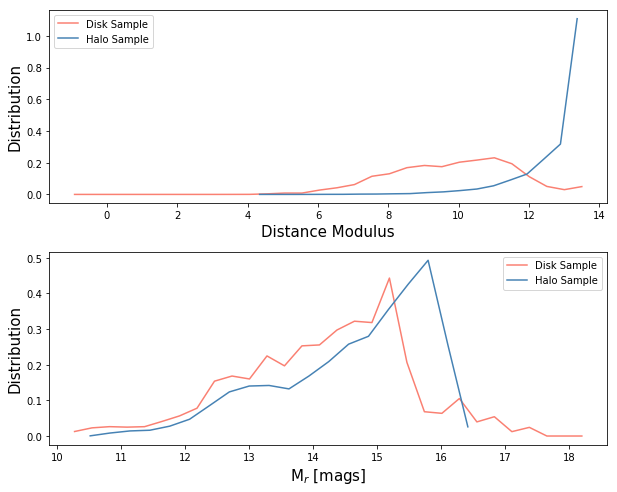

In [116]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Distance Modulus Distribution (x)
ax1.plot(disk_D_bins[:-1],disk_dist_x,color='Salmon',label='Disk Sample')
ax1.plot(halo_D_bins[:-1],halo_dist_x,color='SteelBlue',label='Halo Sample')
ax1.set_ylabel('Distribution',size=15)
ax1.set_xlabel(r'Distance Modulus',size=15)
ax1.legend()

# M_r Distribution (y)
ax2.plot(disk_Mr_bins[:-1],disk_dist_y,color='Salmon',label='Disk Sample')
ax2.plot(halo_Mr_bins[:-1],halo_dist_y,color='SteelBlue',label='Halo Sample')
ax2.set_ylabel('Distribution',size=15)
ax2.set_xlabel(r'M$_r$ [mags]',size=15)
ax2.legend()

plt.subplots_adjust(hspace = .25)
plt.show()

In [117]:
# Read in True LF data
LFdisk = pd.read_csv('WDlumfuncDisk.dat',skiprows=5,delim_whitespace=True,names=['M_r','LF'])
LFhalo = pd.read_csv('WDlumfuncHalo.dat',skiprows=5,delim_whitespace=True,names=['M_r','LF'])

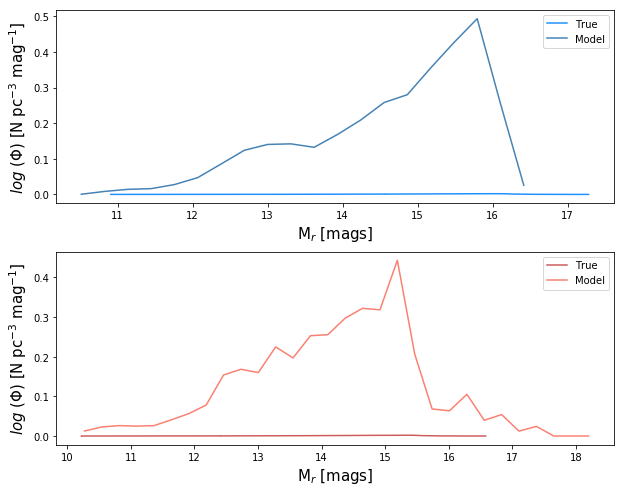

In [119]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Halo Luminosity Function Plots (prior to normalization)
ax1.plot(LFhalo.M_r,LFhalo.LF,color='DodgerBlue',label='True')
ax1.plot(halo_Mr_bins[:-1],halo_dist_y,color='SteelBlue',label='Model')
ax1.set_ylabel(r'$log\ (\Phi)$ [N pc$^{-3}$ mag$^{-1}$]',size=15)
ax1.set_xlabel(r'M$_r$ [mags]',size=15)
ax1.legend()

# Disk Luminosity Function Plots (prior to normalization)
ax2.plot(LFdisk.M_r,LFdisk.LF,color='IndianRed',label='True')
ax2.plot(disk_Mr_bins[:-1],disk_dist_y,color='Salmon',label='Model')
ax2.set_ylabel('$log\ (\Phi)$ [N pc$^{-3}$ mag$^{-1}$]',size=15)
ax2.set_xlabel(r'M$_r$ [mags]',size=15)
ax2.legend()

plt.subplots_adjust(hspace = .25)
plt.show()

In [120]:
# Normalize FUNCTION
def normalize(dist_bins,Mr_bins,LF_x,LF_y,LF_x_err,LF_y_err,disk_or_halo):
    D_cen   = 0.5*(dist_bins[1:]+dist_bins[:-1])
    Mr_cen  = 0.5*(Mr_bins[1:]+Mr_bins[:-1])
    D_cen_N = D_cen[np.argsort(LF_x)][-1]

    N_square = (ob_Gpm_disks.Dmod[0:1000] < 11.0) & (ob_Gpm_disks.M_r[0:1000] < 13.5)
    D_sum    = np.sum((LF_x*(dist_bins[1:]-dist_bins[:-1]))[D_cen <= 11.0])
    Mr_sum   = np.sum((LF_y*(Mr_bins[1:]-Mr_bins[:-1]))[Mr_cen <= 13.5])
    N_const  = np.sum(N_square) / (D_sum*Mr_sum)

    D_pc     = 10. * 10.**(0.2 * D_cen)
    D_sterad = 2. * np.pi * (1. - np.cos(((np.pi/180.)*30.)))  # 90 - 60 = 30. to radians 

    rho     = N_const * 5./np.log(10)/D_sterad / D_pc**3. * LF_x
    rho_err = rho * (LF_x_err / LF_x)

    nan_mask = rho == 0.
    rho  = rho[~nan_mask]
    D_pc = D_pc[~nan_mask]
    rho_err = rho_err[~nan_mask]
    if disk_or_halo == 'd':
        #print('Disk')
        rho_m, rho_b = np.polyfit(D_pc[np.any([D_pc < 200., D_pc > 450.], axis=0)],
                          np.log10(rho[np.any([D_pc < 200., D_pc > 450.], axis=0)]),1)
        rho_0 = 10**rho_b
    else:
        #print('Halo')
        rho_0 = np.median(rho[np.any([D_pc < 500., D_pc > 2000.], axis=0)])
        
    psi     = LF_y * rho_0
    psi_err = psi * (LF_y_err / LF_y)
    return Mr_cen,psi,psi_err,D_pc,rho,rho_err

# DISK
disk_Mr_cen,disk_psi,disk_psi_err,disk_D_pc,disk_rho,disk_rho_err = normalize(disk_D_bins,disk_Mr_bins,
                                                                              disk_dist_x,disk_dist_y,
                                                                              disk_x_err,disk_y_err,'d')
# HALO
halo_Mr_cen,halo_psi,halo_psi_err,halo_D_pc,halo_rho,halo_rho_err = normalize(halo_D_bins,halo_Mr_bins,
                                                                              halo_dist_x,halo_dist_y,
                                                                              halo_x_err,halo_y_err,'h')

/Users/the_neekster/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/Users/the_neekster/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


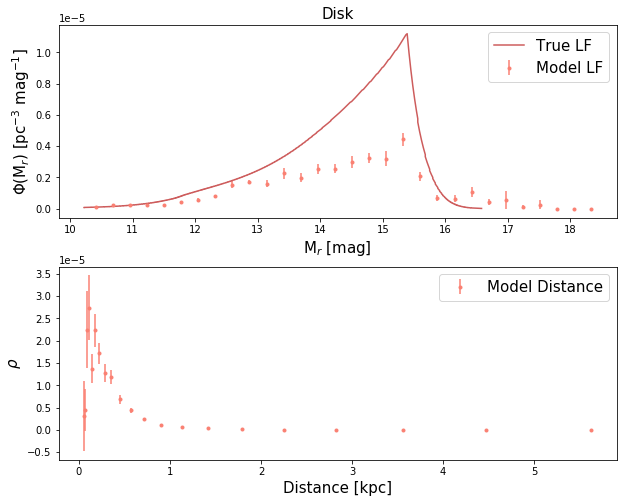

In [121]:
# Plot LF function and observed data 
# Note from HW: Divide LF by 200. (from WDlumfunc*)
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(LFdisk.M_r,LFdisk.LF/200.,color='IndianRed',label='True LF')
ax1.errorbar(disk_Mr_cen,disk_psi,disk_psi_err,color='Salmon',fmt='.',label='Model LF')
ax1.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax1.set_xlabel(r'M$_r$ [mag]',size=15)
ax1.set_ylabel(r'$\Phi$(M$_r$) [pc$^{-3}$ mag$^{-1}$]',size=15)
ax1.legend(fontsize=15)
ax1.set_title('Disk',size=15)

ax2.errorbar(disk_D_pc/1000.,disk_rho,disk_rho_err,color='Salmon',fmt='.',label='Model Distance')
ax2.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax2.set_xlabel('Distance [kpc]',size=15)
ax2.set_ylabel(r'$\rho$',size=15)
ax2.legend(fontsize=15)

plt.subplots_adjust(hspace = .25)
plt.show()

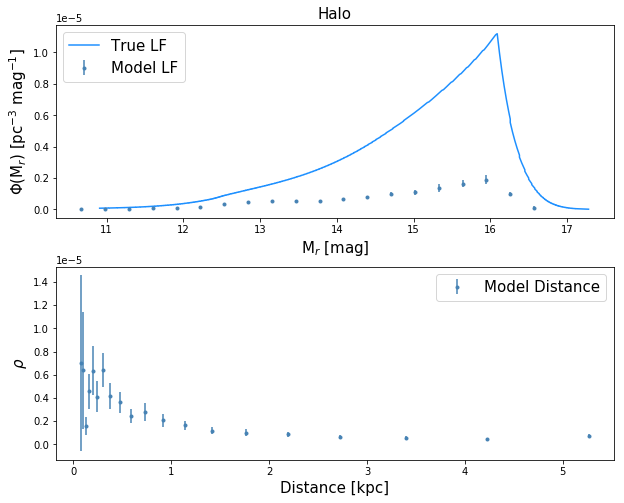

In [113]:
# Plot LF function and observed data 
# Note from HW: Divide LF by 200. (from WDlumfunc*)
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(LFhalo.M_r,LFhalo.LF/200.,color='DodgerBlue',label='True LF')
ax1.errorbar(halo_Mr_cen,halo_psi,halo_psi_err,color='SteelBlue',fmt='.',label='Model LF')
ax1.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax1.set_xlabel(r'M$_r$ [mag]',size=15)
ax1.set_ylabel(r'$\Phi$(M$_r$) [pc$^{-3}$ mag$^{-1}$]',size=15)
ax1.legend(fontsize=15)
ax1.set_title('Halo',size=15)

ax2.errorbar(halo_D_pc/1000.,halo_rho,halo_rho_err,color='SteelBlue',fmt='.',label='Model Distance')
ax2.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax2.set_xlabel('Distance [kpc]',size=15)
ax2.set_ylabel(r'$\rho$',size=15)
ax2.legend(fontsize=15)

plt.subplots_adjust(hspace = .25)
plt.show()

While the overall shape of my model luminosity functions (LF) follow that of the true LF the peak of the LF is far too low. I would also expect the data closer to the edges of the LF to have larger error bars. This discrepancy may be caused by the S/N cuts I required for the bootstrap Cminus method (which resulted in fewer data points).